$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Control a Marble with Reinforcement Learning

*Brent Staab*

## Overview

In this assignment, you will be modifying the reinforcement learning code used to solve the dynamic marble problem.  You will be solving a more complex version of the marble problem in which a goal position is specified as a new state variable.

Start with the code in the notebook for lecture notes 17.

## Requirements

Modify the code from Lecture Notes 17 to change the
reinforcement learning problem to one for which the goal position of
the marble can be varied. In other words, your new code must train one Q network for the marble problem with a variable goal. 

Use the plotting code from Lecture 17 to show your results.  In addition to those plots, create nine additional versions of the lower-right plot for goal positions at 1, 2, 3, 4, 5, 6, 7, 8, and 9.

The general approach is as follows.

The state of the marble is given by $(x_t,
\dot{x_t})$.  In this new problem, the state will be $(x_t,
\dot{x_t}, g_t)$, where $g_t$ is the goal at time $t$.  Modify the
`initialState` function to randomly choose a new goal $g_t$ to be a
random value between 1 and 9. Modify `nextState` so that the goal
value remains the same in the new state as it was in the old state.  You will also
have to modify the reinforcement function to depend on the
current $g_t$ value.

Many of the figures will still make sense.  Include them in your
report.  The contour (and surface)
plots and the plot that tests the marble's behavior for various intial
positions must be produced for a single value of the goal.  Generate
several versions of the contour and surface plots and the test plots for goals of 1, 5, and 9 to show how
they vary when the goal is varied.

Experiment with values of the parameters, such as the number of trials, number of
steps per trial, number of SCG iterations in each train call, number of hidden units, finalEpsilon, and gamma.  Try
to find values that result in a trained network that controls the
marble well for most of the goal settings.
Discuss your experience with finding good parameter values.

Discuss the changes you tried and the results.

## Import code needed in this notebook

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetworks as nn   # from notes 09
import copy


from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import warnings
warnings.filterwarnings("ignore")

## Global variables

In [2]:
actions = None
X = None
R = None
Qn = None

## Definition of functions

In [3]:
def reinforcement(s, s1):
    goal = s[2]
    return 0 if abs(s1[0] - goal) < 1 else -1

In [4]:
def initialState(goal=None):
    # [0] - position   (0 - 10)
    # [1] - velocity   (0)
    # [2] - goal state (1 - 9)
    if goal == None:
        goal = np.random.uniform(low=1.0, high=9.0)
    return np.array([10 * np.random.random_sample(), 0.0, goal])

In [5]:
def nextState(s, a):
    # s[0] - position   (0 - 10)
    # s[1] - velocity   (0)
    # s[2] - goal state (1 - 9)
    # a is the action -1, 0 or 1
    s = copy.copy(s)                       # Make a copy so we don't modify the input
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
                                           # s[2], a.k.a. the goal, remains unchanged
        
    if s[0] < 0:                           # Bound next position. If at limits, set velocity to 0.
        s = [ 0, 0, s[2]]
    elif s[0] > 10:
        s = [10, 0, s[2]]
        
    return s

In [6]:
def epsilonGreedy(nnetQ, state, actions, epsilon):
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)
    else:
        # Greedy Move
        Qs = [nnetQ.use(np.hstack((state, a)).reshape((1, -1))) for a in actions]
        ai = np.argmax(Qs)
        action = actions[ai]
    
    Q = nnetQ.use(np.hstack((state, action)).reshape((1, -1)))
    return action, Q

In [7]:
def makeSamples(nnet, initialStateF, nextStateF, reinforcementF,
                validActions, numSamples, epsilon):

    X = np.zeros((numSamples, nnet.n_inputs))
    R = np.zeros((numSamples, 1))
    Qn = np.zeros((numSamples, 1))

    s = initialStateF()
    sn = nextStateF(s, 0)        # Update state, sn from s and a
    a, _ = epsilonGreedy(nnet, s, validActions, epsilon)

    # Collect data from numSamples steps
    for step in range(numSamples):
        sn = nextStateF(s, a)        # Update state, sn from s and a
        rn = reinforcementF(s, sn)   # Calculate resulting reinforcement
        an, qn = epsilonGreedy(nnet, sn, validActions, epsilon) # Forward pass for time t+1
        X[step, :] = np.hstack((s, a))
        R[step, 0] = rn
        Qn[step, 0] = qn
        # Advance one time step
        s, a = sn, an

    return (X, R, Qn)

In [8]:
def plotStatus(net, trial, epsilonTrace, rtrace):
    global actions
    global X
    goal = X[trial,2]
    
    plt.subplot(4, 3, 1)
    plt.plot(epsilonTrace[:trial + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)
    
    plt.subplot(4, 3, 2)
    plt.plot(X[:, 0])
    plt.plot([0, X.shape[0]], [goal, goal], '--', alpha=0.5, lw=5)
    plt.ylabel('$x$')
    plt.ylim(-1, 11)
    qs = net.use(np.array([[s, 0, goal, a] for a in actions for s in range(11)]))
    
    plt.subplot(4, 3, 3)
    # This is to support both base assignment and extra credit
    # The base assignment has three actions while the extra credit has seven
    if len(actions) == 3:
        acts = ['L', '0', 'R']
    else:
        acts = ['LL', 'Ll', 'L', '0', 'R', 'Rr', 'RR']
    actsiByState = np.argmax(qs.reshape((len(actions), -1)), axis=0)
    for i in range(11):
        plt.text(i, 0, acts[actsiByState[i]])
        plt.xlim(-1, 11)
        plt.ylim(-1, 1)
    plt.text(2, 0.2, 'Policy for Zero Velocity')
    plt.axis('off')
    
    plt.subplot(4, 3, 4)
    plt.plot(rtrace[:trial + 1], alpha=0.5)
    binSize = 20
    if trial + 1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial / binSize) * binSize].reshape((int(trial / binSize), binSize)),
                           axis=1)
        plt.plot(np.arange(1, 1 + int(trial / binSize)) * binSize, smoothed)
    plt.ylabel('Mean reinforcement')
    
    plt.subplot(4, 3, 5)
    plt.plot(X[:, 0], X[:, 1])
    plt.plot(X[0, 0], X[0, 1], 'o')
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    x_min = goal - 1 if goal >= 1 else 0
    x_max = goal + 1 if goal <= 9 else 10
    plt.fill_between([x_min, x_max], [-5, -5], [5, 5], color='red', alpha=0.3)
    plt.xlim(-1, 11)
    plt.ylim(-5, 5)
    plt.subplot(4, 3, 6)
    net.draw(['$x$', '$\dot{x}$', '$a$'], ['Q'])
    
    plt.subplot(4, 3, 7)
    n = 20
    positions = np.linspace(0, 10, n)
    velocities =  np.linspace(-5, 5, n)
    xs, ys = np.meshgrid(positions, velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = net.use(np.array([[xsflat[i], ysflat[i], goal, a] for a in actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(actions), -1)).T
    qsmax = np.max(qs, axis=1).reshape(xs.shape)
    cs = plt.contourf(xs, ys, qsmax)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Max Q')
    
    plt.subplot(4, 3, 8)
    acts = np.array(actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Actions')
    
    s = plt.subplot(4, 3, 10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(), rect=rect)
    ax.plot_surface(xs, ys, qsmax, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Max Q')
    
    s = plt.subplot(4, 3, 11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(), rect=rect)
    ax.plot_surface(xs, ys, acts, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Action')
    
    plt.tight_layout()

In [9]:
def testIt(Qnet, nTrials, nStepsPerTrial):
    xs = np.linspace(0, 10, nTrials)
    goal = np.random.uniform(low=1.0, high=9.0)
    plt.subplot(4, 3, 12)
    for x in xs:
        s = [x, 0, goal]
        xtrace = np.zeros((nStepsPerTrial, 3))
        for step in range(nStepsPerTrial):
            a,_ = epsilonGreedy(Qnet, s, actions, 0.0) # epsilon = 0
            s = nextState(s, a)
            xtrace[step, :] = s
        plt.plot(xtrace[:, 0], xtrace[:, 1])
        plt.xlim(-1, 11)
        plt.ylim(-5, 5)
        plt.plot([goal, goal], [-5, 5], '--', alpha=0.5, lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

In [10]:
def setupStandardization(net, Xmeans, Xstds, Tmeans, Tstds):
    net.Xmeans = Xmeans
    net.XstdsFixed = Xstds
    net.Xconstant = [False] * len(Xmeans)
    net.TstdsFixed = net.Tstds = Tstds
    net.Tmeans = Tmeans
    net.Tconstant = [False] * len(Tstds)

#### User defined helper functions

In [11]:
# Helper function to generate the 'state trajectory' plots.
# This is similar to the testIt() function. This function accepts the 
# goal state(s) and generates a plot for each goal
# NOTE: It assumes that the length of goals is <= 9
def stateTrajectories(Qnet, nTrials, nStepsPerTrial, goals):
    _goals = copy.copy(goals)
    if type(_goals) != list:
        _goals = [_goals]
        
    fig = plt.figure(figsize=(20 ,10))
    xs = np.linspace(0, 10, 10)
    for goal in _goals:
        for x in xs:
            s = [x, 0, goal]
            xtrace = np.zeros((nStepsPerTrial, 3))
            for step in range(nStepsPerTrial):
                a,_ = epsilonGreedy(Qnet, s, actions, 0.0) # epsilon = 0
                s = nextState(s, a)
                xtrace[step, :] = s
            plt.subplot(3, 3, goal)
            plt.plot(xtrace[:, 0], xtrace[:, 1], label=f'Xstart {x:.2f}')
            plt.xlim(-1, 11)
            plt.ylim(-5, 5)
            plt.plot([goal, goal], [-5, 5], '--', alpha=0.5, lw=5)
            plt.ylabel('$\dot{x}$')
            plt.xlabel('$x$')
            plt.title(f'State Trajectories for goal = {goal}')
            plt.grid(True)
            plt.subplots_adjust(left=0.125, bottom=0.0, right=0.9, top=1.0, wspace=0.2, hspace=0.2)

In [12]:
# Helper function to generate the contour and surface plots.
def contourAndSurfacePlot(Qnet, goals, nStepsPerTrial):
    _goals = copy.copy(goals)
    if type(_goals) != list:
        _goals = [_goals]
    
    
    for goal in _goals:
        fig = plt.figure(figsize=(20 ,10))
        title = f'Goal ({goal})'
        plt.suptitle(title, fontsize=14, fontweight='bold', y=1.00)

        n = 20
        positions = np.linspace(0, 10, n)
        velocities =  np.linspace(-5, 5, n)
        xs, ys = np.meshgrid(positions, velocities)
        xsflat = xs.flat
        ysflat = ys.flat
        cnt = 1
        plt.subplot(2, 3, cnt)
        n = 20
        positions = np.linspace(0, 10, n)
        velocities =  np.linspace(-5, 5, n)
        xs, ys = np.meshgrid(positions, velocities)
        xsflat = xs.flat
        ysflat = ys.flat
        qs = Qnet.use(np.array([[xsflat[i], ysflat[i], goal, a] for a in actions for i in range(len(xsflat))]))
        qs = qs.reshape((len(actions), -1)).T
        qsmax = np.max(qs, axis=1).reshape(xs.shape)
        cs = plt.contourf(xs, ys, qsmax)
        plt.colorbar(cs)
        plt.xlabel('$x$')
        plt.ylabel('$\dot{x}$')
        plt.title('Max Q')
        cnt += 1
        plt.subplot(2, 3, cnt)
        acts = np.array(actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
        cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2])
        plt.colorbar(cs)
        plt.xlabel('$x$')
        plt.ylabel('$\dot{x}$')
        plt.title('Actions')
        cnt += 2 # Skip a plot 
        s = plt.subplot(2, 3, cnt)
        rect = s.get_position()
        ax = Axes3D(plt.gcf(), rect=rect)
        ax.plot_surface(xs, ys, qsmax, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$\dot{x}$')
        plt.title('Max Q')
        cnt += 1
        s = plt.subplot(2, 3, cnt)
        rect = s.get_position()
        ax = Axes3D(plt.gcf(), rect=rect)
        ax.plot_surface(xs, ys, acts, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$\dot{x}$')
        plt.title('Action')
        
        cnt += 1
        xs = np.linspace(0, 10, 10)
        for x in xs:
            s = [x, 0, goal]
            xtrace = np.zeros((nStepsPerTrial, 3))
            for step in range(nStepsPerTrial):
                a,_ = epsilonGreedy(Qnet, s, actions, 0.0) # epsilon = 0
                s = nextState(s, a)
                xtrace[step, :] = s
            plt.subplot(2, 3, cnt)
            plt.plot(xtrace[:, 0], xtrace[:, 1], label=f'Xstart {x:.2f}')
            plt.xlim(-1, 11)
            plt.ylim(-5, 5)
            plt.plot([goal, goal], [-5, 5], '--', alpha=0.5, lw=5)
            plt.ylabel('$\dot{x}$')
            plt.xlabel('$x$')
            plt.title(f'State Trajectories for goal = {goal}')
            plt.grid(True)
            #plt.subplots_adjust(left=0.125, bottom=0.0, right=0.9, top=1.0, wspace=0.2, hspace=0.2)
            #plt.legend()

In [35]:
# Helper function to create a network and run a specific experiment
# Parameters:
#    gamma          - discount factor
#    nTrials        - number of repetitions of makeSamples-updateQ loop
#    nStepsPerTrial - number of steps between new random initial states
#    nSCGIterations - maximum number of SCG iterations
#    finalEpsilon   - value of epsilon at end of simulation. Decay rate is calculated
def experiment(gamma, nTrials, nStepsPerTrial, nSCGIterations, nh, finalEpsilon, extrCredit=False):
    global actions
    global X
    global R
    global Qn
    
    if extrCredit:
        actions = (-2, -1.5, -1, 0, 1, 1.5, 2.0)   # Possible actions
    else:
        actions = (-1, 0, 1)   # Possible actions
        
    fig = plt.figure(figsize=(10 ,10))
    epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
    print('epsilonDecay is',epsilonDecay)

    _nh = nh           # number of hidden units
    nnetQ = nn.NeuralNetwork(4, _nh, 1)
    # Inputs are position (1 to 10) velocity (-3 to 3) goal (1 to 9) and action (-1, 0, or 1)
    setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 0.5, 0.5], [0], [1])

    epsilon = 1         # initial epsilon value
    epsilonTrace = np.zeros(nTrials)
    rtrace = np.zeros(nTrials)
    for trial in range(nTrials):
        # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
        X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
        nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

        # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
        # Rest is for plotting
        epsilonTrace[trial] = epsilon
        epsilon *= epsilonDecay
        rtrace[trial] = np.mean(R)
        if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
            fig.clf()
            plotStatus(nnetQ, trial, epsilonTrace, rtrace)
            testIt(nnetQ, 10, 500)
            clear_output(wait=True)
            display(fig)

    clear_output(wait=True)
    return nnetQ

## Experiment

Make several other changes in the code to handle the changes you have made to the state representation.  Use the plotting code from Lecture 17 to show your results.

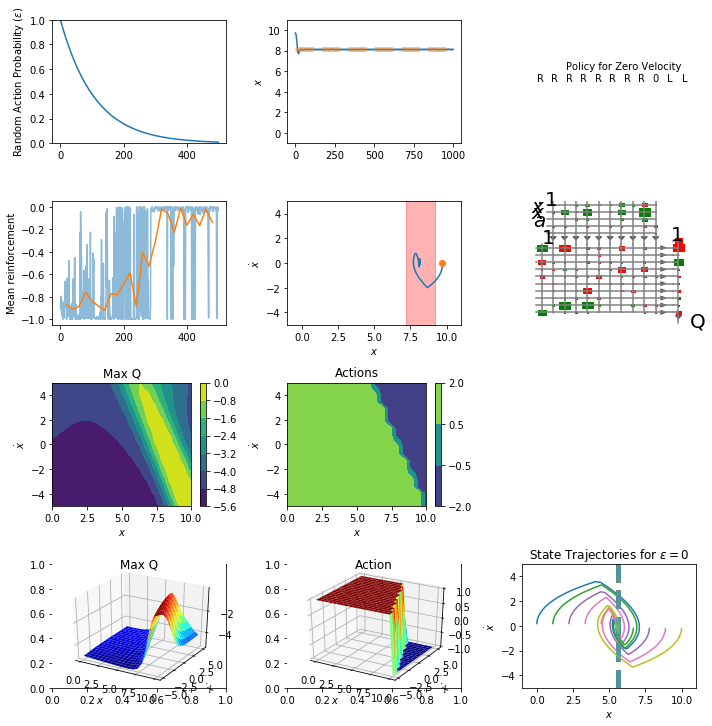

In [14]:
# This is the experiment defined in notebook 17
net = experiment(0.8, 500, 1000, 4, [10, 10], 0.01)

The overall performance of the network, after being trained for 500 iterations, is quite good.  From plot number two (first row, middle column), the marble reaches the goal state quickly and remains stable over the remaining steps in the trial.  Also, the 'State Trajectory' plot (last row, last column), shows the trajectory for a variety of starting position and fixed goal (~4.2). You can see that all marbles initially overshoot the goal state but eventually converge.  It's worth noting that this network might not be the best if the objective is to reach the goal in the fewest number of steps.  Specifically, based on the Euclidian distance, the overshooting of the goal means more steps are needed than strictly required.

##### In addition to those plots, create nine additional versions of the lower-right plot for goal positions at 1, 2, 3, 4, 5, 6, 7, 8, and 9.

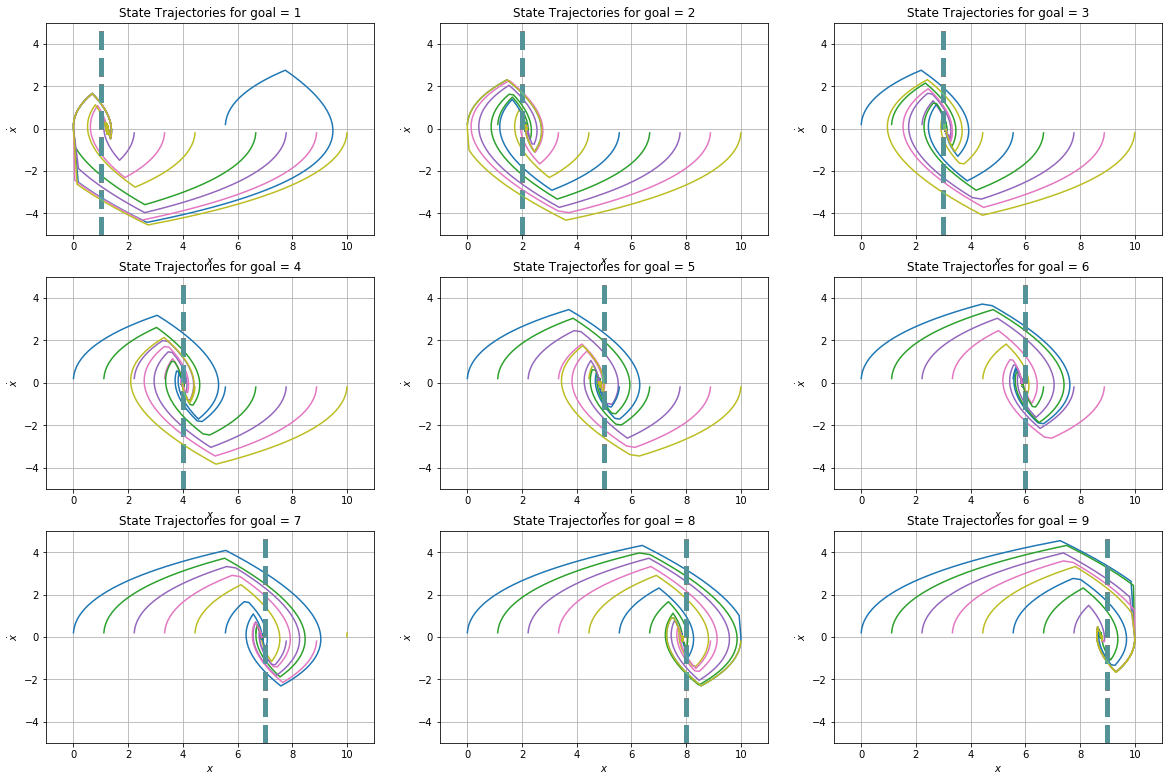

In [16]:
stateTrajectories(net, 500, 1000, [*range(1, 10, 1)])

The nine plots above show the 'State Trajectories' for a marble with ten different starting positions and a fixed goal.  Overall, the marbles converge to the desired goal state.   They all exhibit an overshoot but ultimately end up where we want them too.  I don't understand the first plot, where the goal position is one.  It almost looks like the marble is converging on two values (one and eight).  It might be an artifact of the plotting the specific data set, but I was not able to find the root cause.

##### Generate several versions of the contour and surface plots and the test plots for goals of 1, 5, and 9 to show how they vary when the goal is varied.

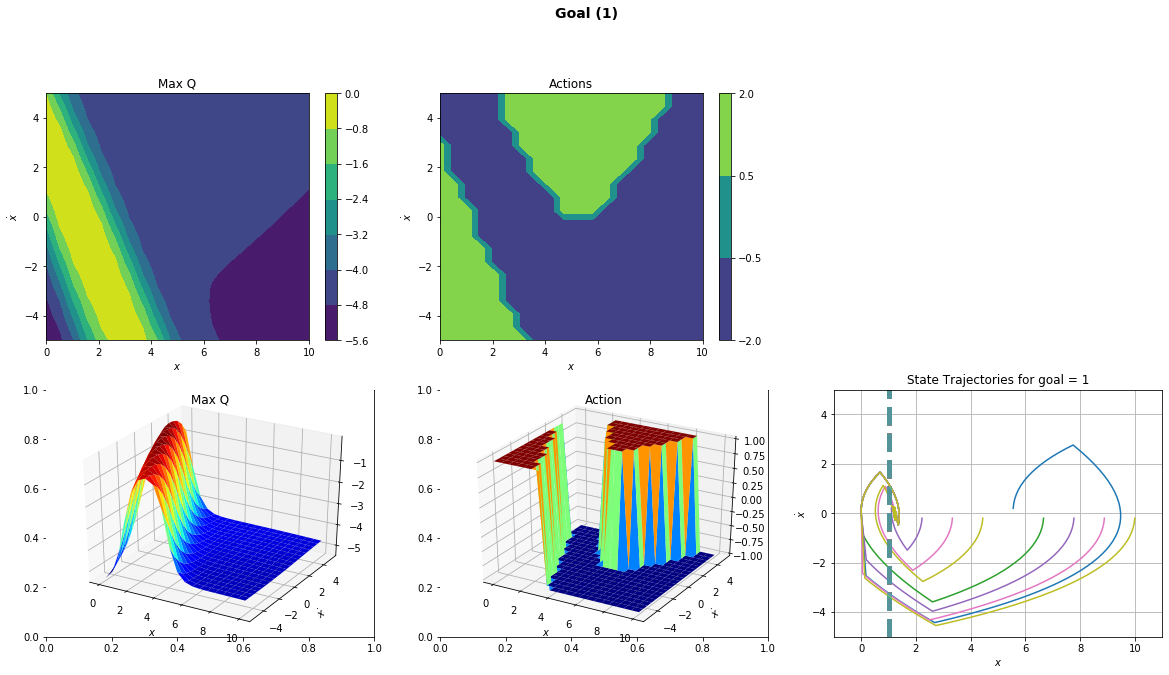

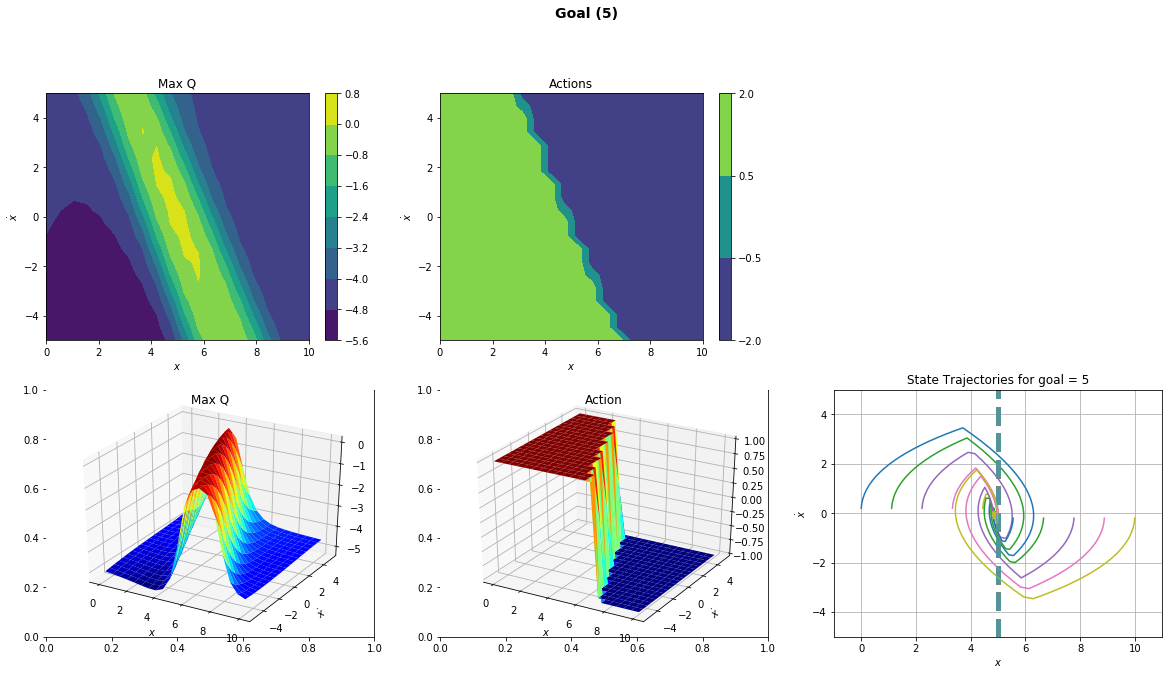

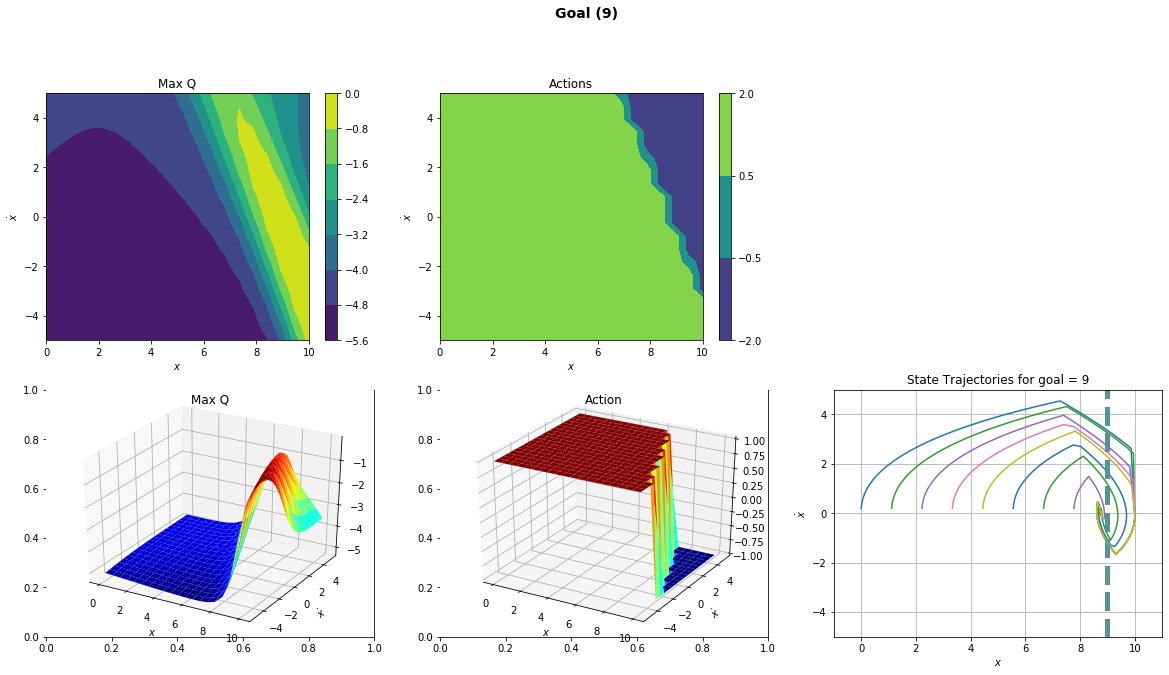

In [17]:
contourAndSurfacePlot(net, [1,5,9], 1000)

The plots above are contour, surface and test plots for goals of 1, 5, and 9.  This shows how the behavior varies based on the goal value.  The plots and observations are similar to the previous experiments in this notebook.

##### Experiment with values of the parameters, such as the number of trials, number of steps per trial, number of SCG iterations in each train call, number of hidden units, finalEpsilon, and gamma.

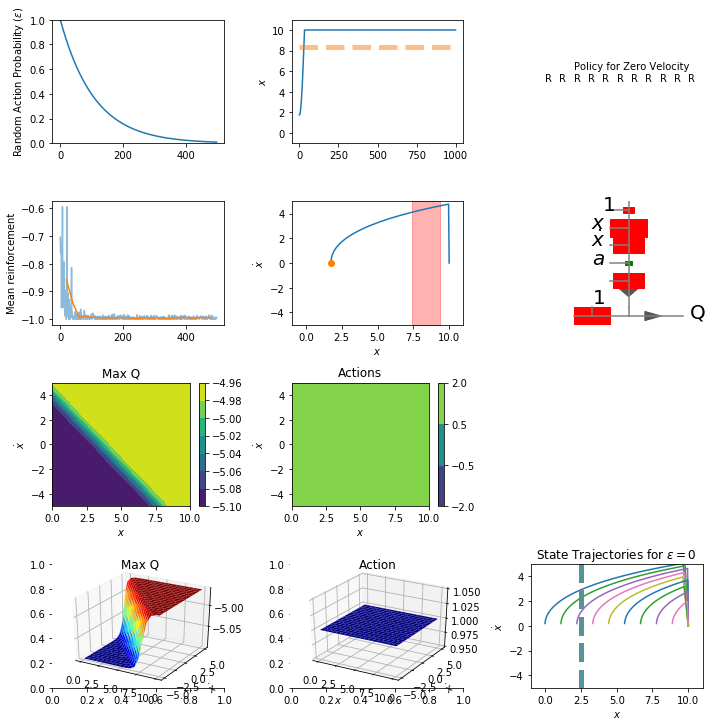

In [30]:
# Hidden layers and units -- minimum of each
# experiment(gamma, nTrials, nStepsPerTrial, nSCGIterations, nh, finalEpsilon):
# baseline experiment(0.8, 500, 1000, 4, [10, 10], 0.01)
net = experiment(0.8, 500, 1000, 4, [1], 0.01)

Overall, the performance of this network, with one hidden layer and a single unit, appears to behave similar to the baseline configuration.  Plot number two (first row, middle column) shows the marble getting to the goal position relatively quickly, then maintaining this position for the duration of hte experiment.  Plot number five (second row, middle column) shows the marble converging on the goal state.  Both are essentially identical to the baseline.  The state trajectory plot looks completely messed up for this experiment.

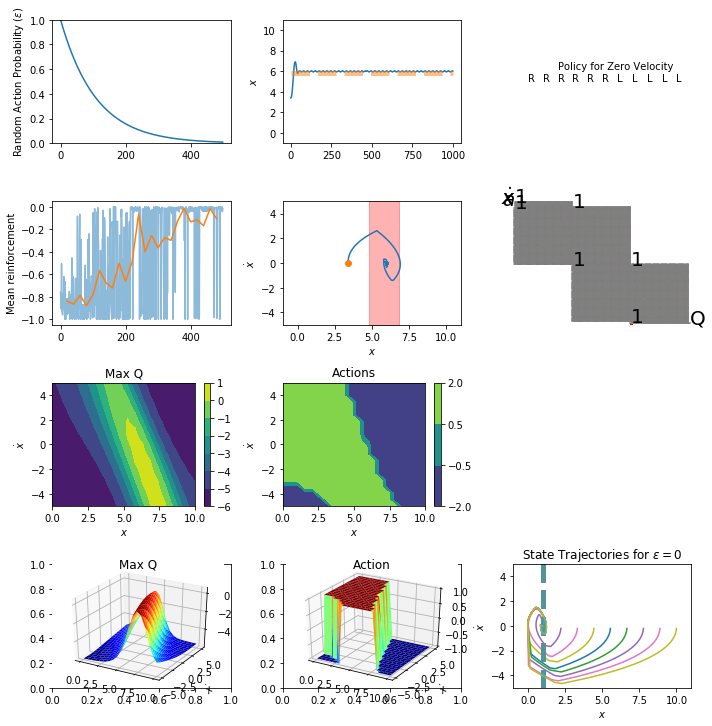

In [31]:
# Hidden layers and units -- maximum of each
# experiment(gamma, nTrials, nStepsPerTrial, nSCGIterations, nh, finalEpsilon):
# baseline experiment(0.8, 500, 1000, 4, [10, 10], 0.01)
net = experiment(0.8, 500, 1000, 4, [50, 50, 50, 50, 50], 0.01)

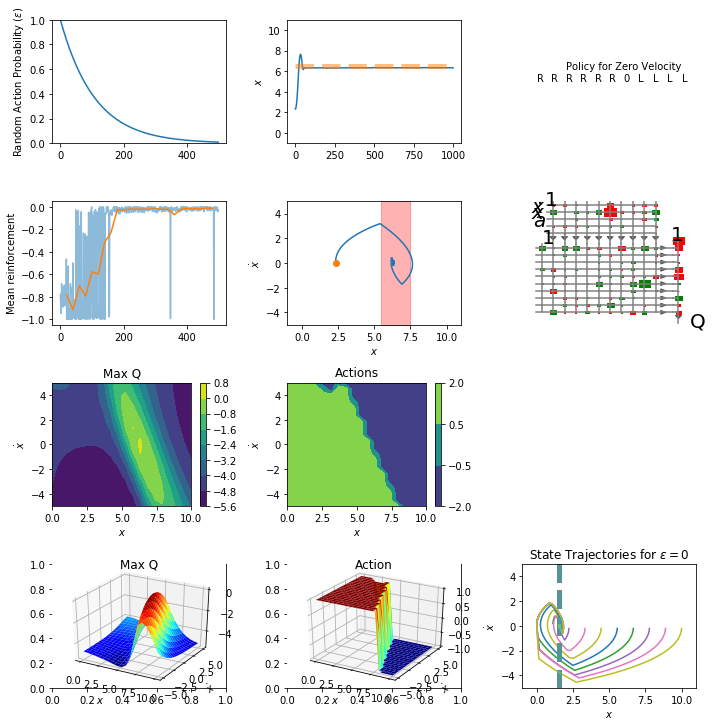

In [20]:
# gamma
# experiment(gamma, nTrials, nStepsPerTrial, nSCGIterations, nh, finalEpsilon):
# baseline experiment(0.8, 500, 1000, 4, [10, 10], 0.01)
net = experiment(0.8, 500, 1000, 4, [10, 10], 0.01)

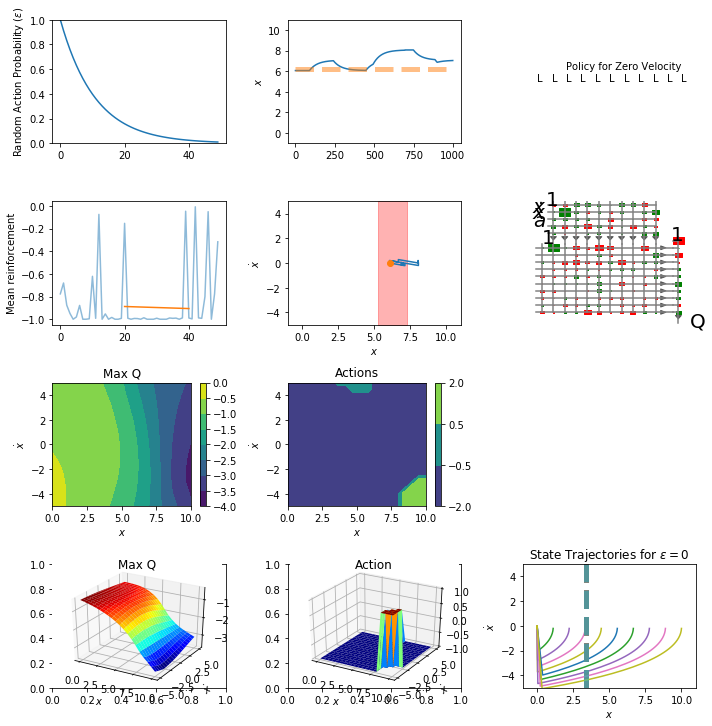

In [32]:
# Number of trials (min)
# experiment(gamma, nTrials, nStepsPerTrial, nSCGIterations, nh, finalEpsilon):
# baseline experiment(0.8, 500, 1000, 4, [10, 10], 0.01)
net = experiment(0.8, 50, 1000, 4, [10, 10], 0.01)

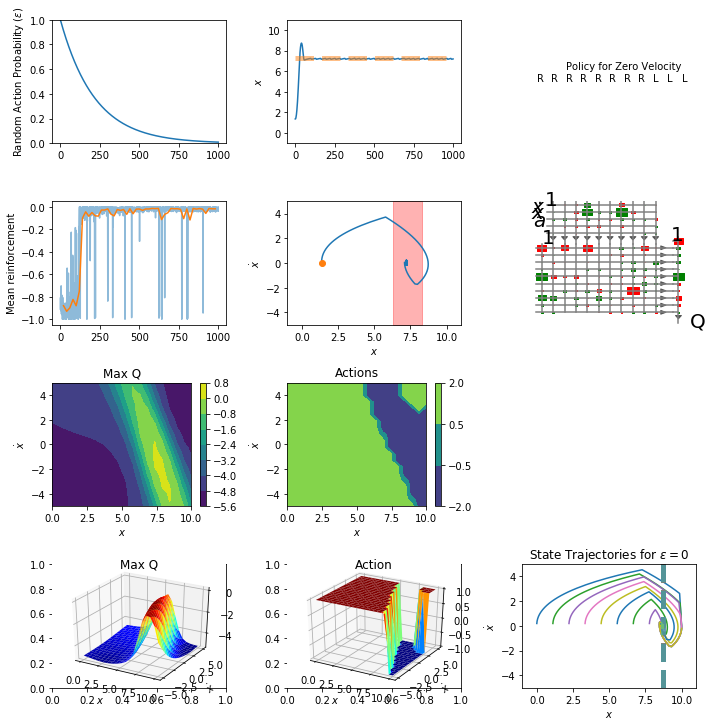

In [26]:
# Number trials (max)
# experiment(gamma, nTrials, nStepsPerTrial, nSCGIterations, nh, finalEpsilon):
# baseline experiment(0.8, 500, 1000, 4, [10, 10], 0.01)
net = experiment(0.8, 1000, 1000, 4, [10, 10], 0.01)

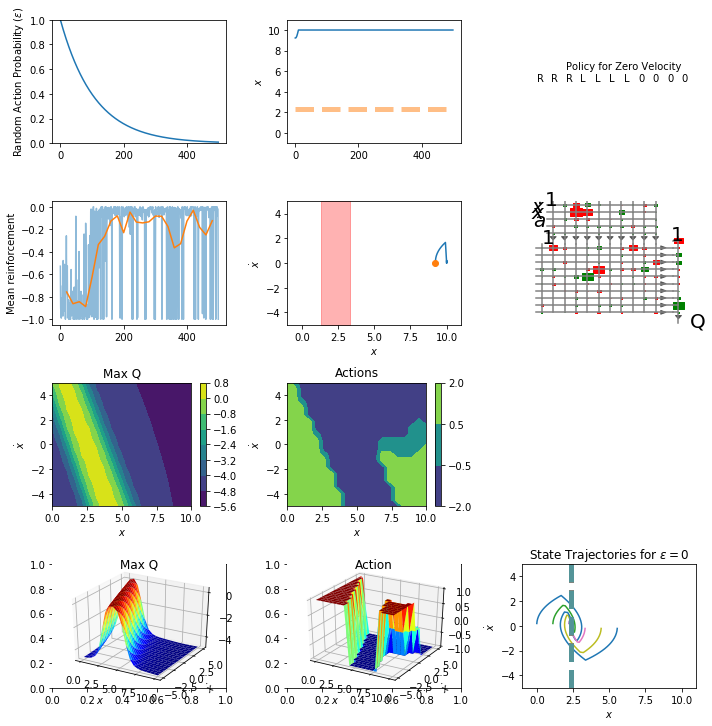

In [25]:
# Steps per trial (min)
# experiment(gamma, nTrials, nStepsPerTrial, nSCGIterations, nh, finalEpsilon):
# baseline experiment(0.8, 500, 1000, 4, [10, 10], 0.01)
net = experiment(0.8, 500, 500, 4, [10, 10], 0.01)

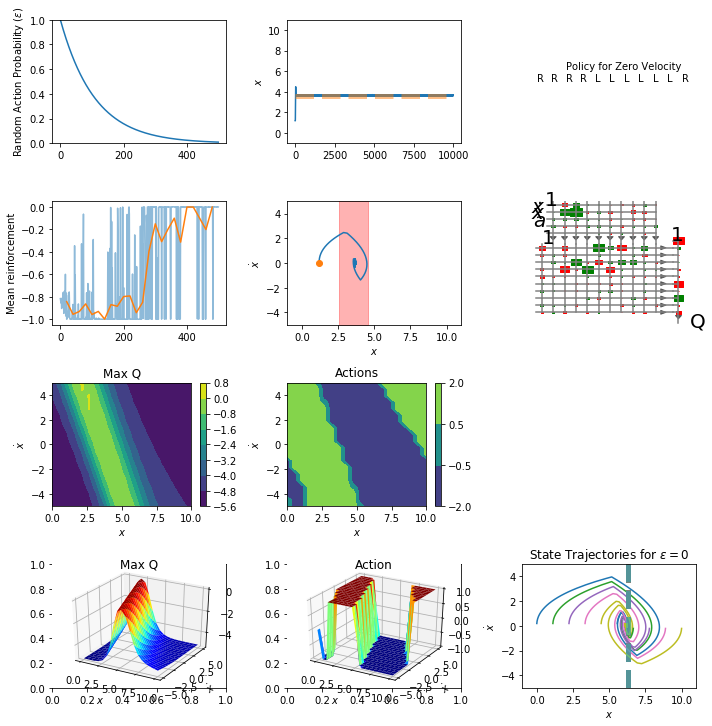

In [27]:
# Steps per trial (max)
# experiment(gamma, nTrials, nStepsPerTrial, nSCGIterations, nh, finalEpsilon):
# baseline experiment(0.8, 500, 1000, 4, [10, 10], 0.01)
net = experiment(0.8, 500, 10000, 4, [10, 10], 0.01)

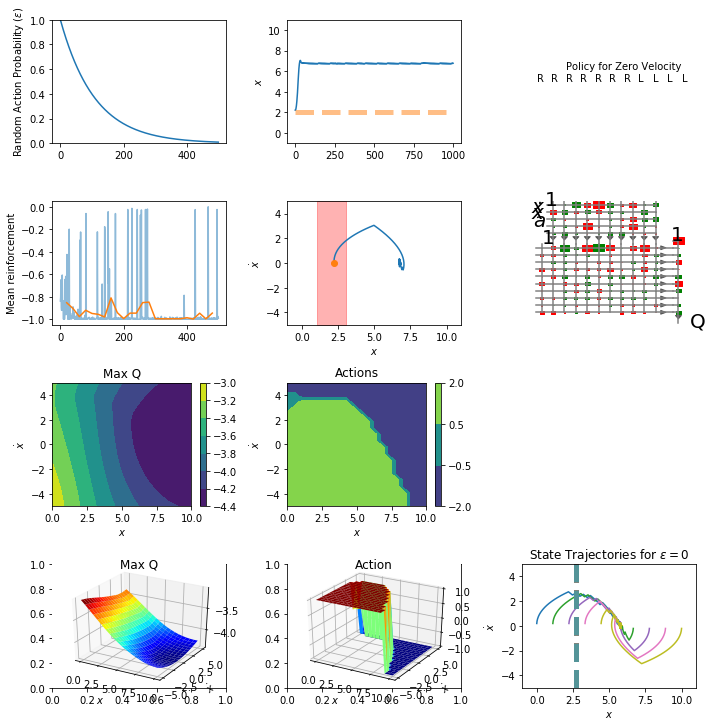

In [33]:
# sgd iterations min
# experiment(gamma, nTrials, nStepsPerTrial, nSCGIterations, nh, finalEpsilon):
# baseline experiment(0.8, 500, 1000, 4, [10, 10], 0.01)
net = experiment(0.8, 500, 1000, 1, [10, 10], 0.01)

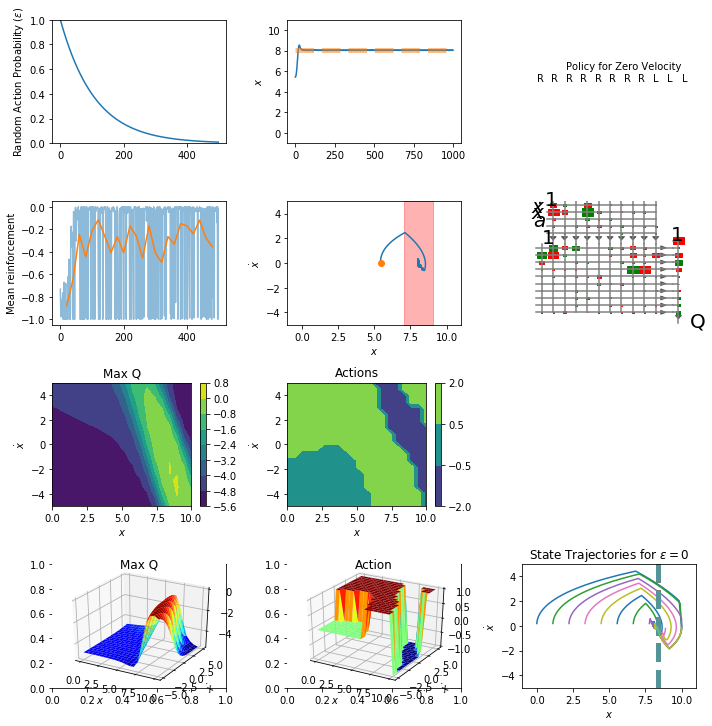

In [29]:
# sgd iterations (max)
# experiment(gamma, nTrials, nStepsPerTrial, nSCGIterations, nh, finalEpsilon):
# baseline experiment(0.8, 500, 1000, 4, [10, 10], 0.01)
net = experiment(0.8, 500, 1000, 20, [10, 10], 0.01)

## Extra Credit

One point of extra credit will be given for completing each of the following things.

* Change the marble's world from one dimension to two. Add graphs of the marble's movement in the two-dimensional plane.
* Increase the number of valid actions from three to seven and discuss the difference between the required runs and these new runs.
* Add a variable wind as a force on the marble, along with another state variable that indicates wind speed and direction.
* Add a second marble with its own RL agent.  Add negative reinforcement if they bump into each other.
* Add areas of increased friction to the track.

For all of these, demonstrate the effects and write about what you observe.  Full extra credit points will only be awarded if you clearly describe your work and results for each point.

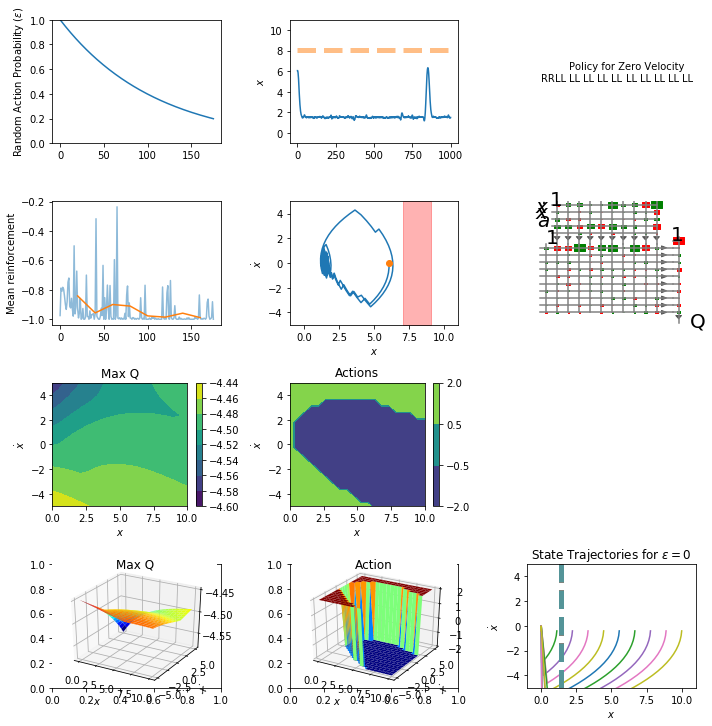

KeyboardInterrupt: 

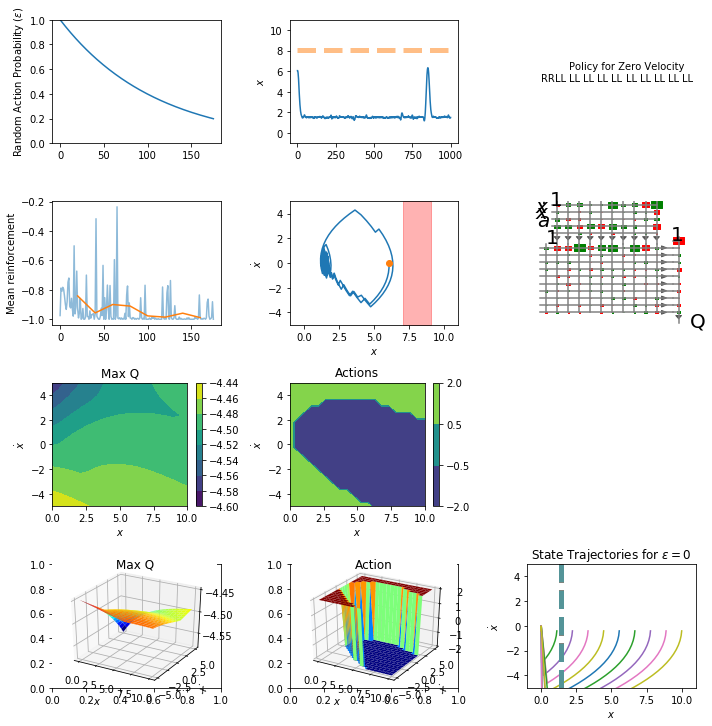

In [34]:
actions = (-2, -1.5, -1, 0, 1, 1.5, 2.0)   # Possible actions
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) goal (1 to 9) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 0.5, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,acthttp://localhost:8888/notebooks/CS545_MachineLearning/assignments/A5/Staab-A5.ipynb#ions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

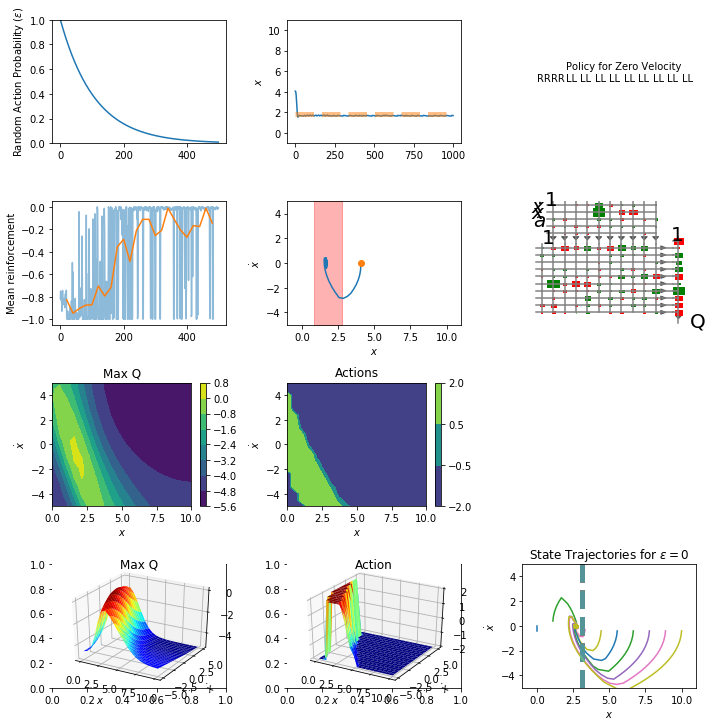

In [36]:
net = experiment(0.8, 500, 1000, 4, [10, 10], 0.01, True)

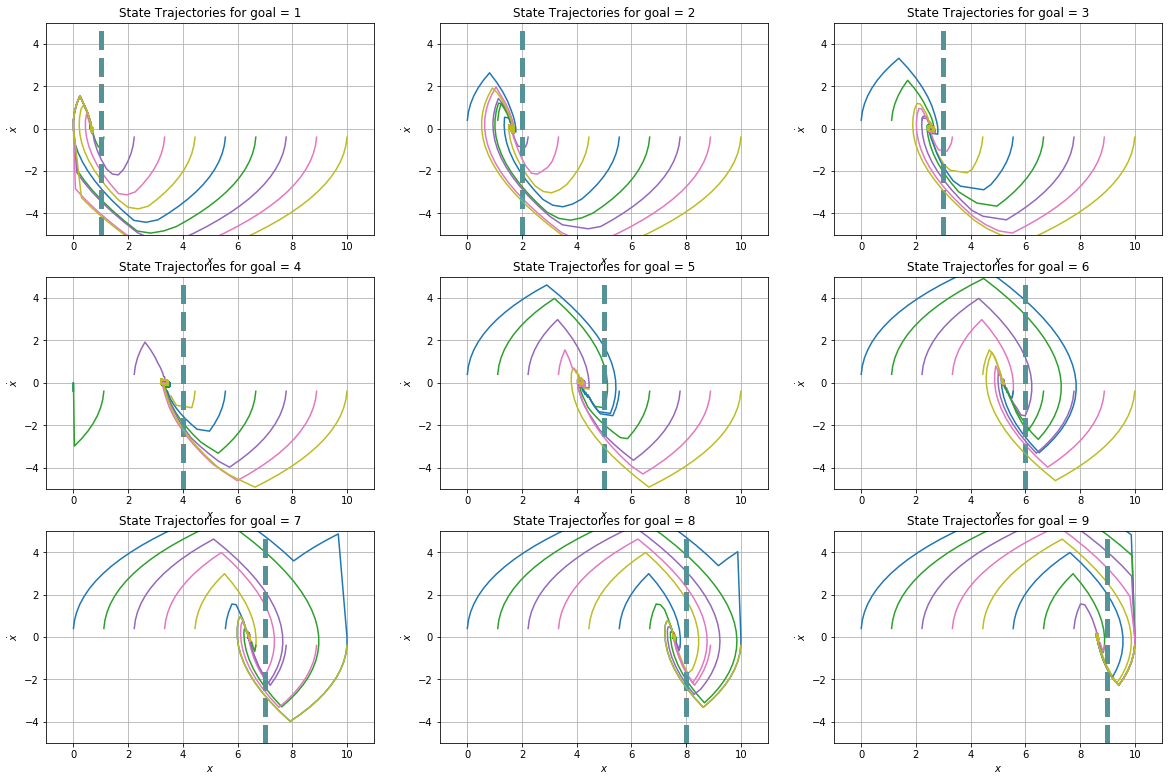

In [39]:
stateTrajectories(net, 500, 1000, [*range(1, 10, 1)])

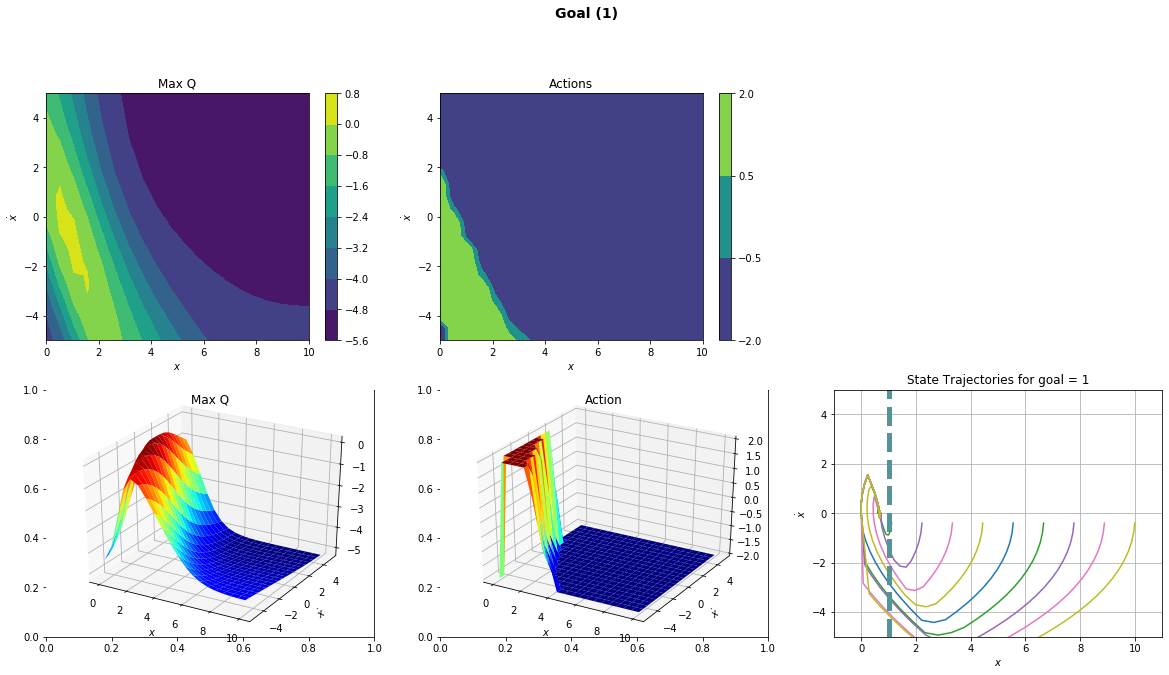

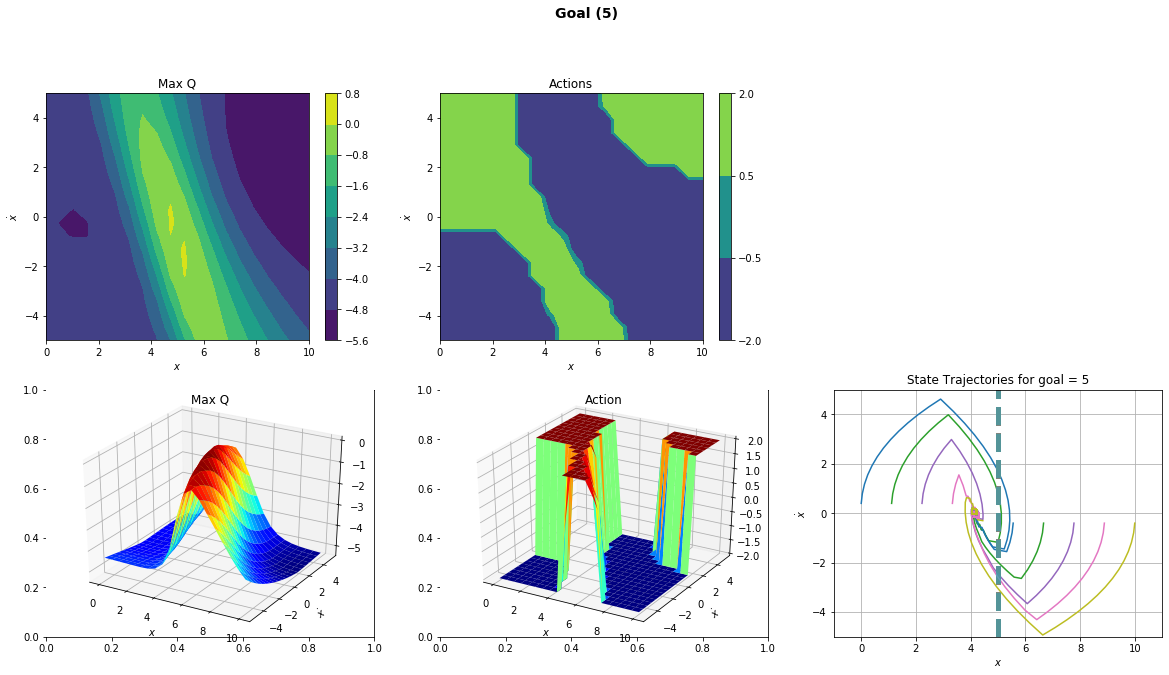

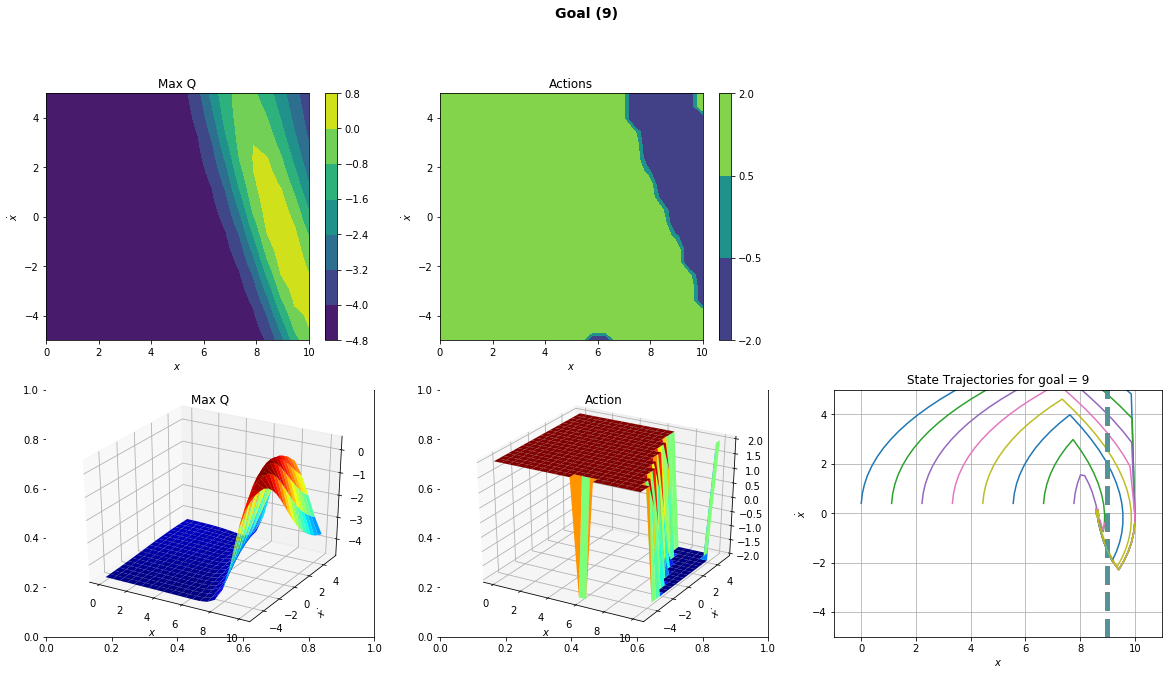

In [40]:
contourAndSurfacePlot(net, [1,5,9], 1000)

## Grading

In [41]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Staab-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

######################################################################
Testing

s = initialState(6.6)


--- 20/20 points. initialState correctly returns goal of 6.6 as third component.

######################################################################
Testing

r = reinforcement(np.array([2.8, 2, 3]), np.array([3.6, 1, 3]))


--- 20/20 points. reinforcement correctly returns 0.

######################################################################
Testing

r = reinforcement(np.array([7., 2., 3.]), np.array([8., 1., 3.]))


--- 20/20 points. reinforcement correctly returns -1.

######################################################################
Testing

s_next = nextState(np.array([1.0, 0.0, 7.0]), 1.0)



--- 10/10 points. nextState correctly 

<Figure size 432x288 with 0 Axes>

## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A5.ipynb```.  So, for me it would be ```Anderson-A5.ipynb```.  Submit the file using the ```Assignment 5``` link on [Canvas](https://colostate.instructure.com/courses/41327).
